# Project - Airline AI Assistant

We'll now bring together what we've learned to make an AI Customer Support assistant for an Airline

In [1]:
# imports

import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr

In [2]:
# Load the openai model from the github models
load_dotenv(override=True)
token = os.getenv("GITHUB_TOKEN")
endpoint = "https://models.inference.ai.azure.com"

model = "gpt-4o-mini"

openai = OpenAI(
    base_url=endpoint,
    api_key=token,
)

In [3]:
system_message = "You are a helpful assistant for an Airline called FlightAI. "
system_message += "Give short, courteous answers, no more than 1 sentence. "
system_message += "Always be accurate. If you don't know the answer, say so."

In [ ]:
# This function looks rather simpler than the one from my video, because we're taking advantage of the latest Gradio updates

def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=model, messages=messages)
    return response.choices[0].message.content

gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


## Tools

Tools are an incredibly powerful feature provided by the frontier LLMs.

With tools, you can write a function, and have the LLM call that function as part of its response.

Sounds almost spooky.. we're giving it the power to run code on our machine?

Well, kinda.

In [5]:
# Let's start by making a useful function

ticket_prices = {"london": "$799", "paris": "$899", "tokyo": "$1400", "berlin": "$499"}

def get_ticket_price(destination_city):
    print(f"Tool get_ticket_price called for {destination_city}")
    city = destination_city.lower()
    return ticket_prices.get(city, "Unknown")

In [6]:
get_ticket_price("London")

Tool get_ticket_price called for London


'$799'

In [7]:
# There's a particular dictionary structure that's required to describe our function:

price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price, for example when a customer asks 'How much is a ticket to this city'",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

In [8]:
# And this is included in a list of tools:

tools = [{"type": "function", "function": price_function}]

## Getting OpenAI to use our Tool

There's some fiddly stuff to allow OpenAI "to call our tool"

What we actually do is give the LLM the opportunity to inform us that it wants us to run the tool.

Here's how the new chat function looks:

In [9]:
# We have to write that function handle_tool_call:

def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get('destination_city')
    price = get_ticket_price(city)
    response = {
        "role": "tool",
        "content": json.dumps({"destination_city": city,"price": price}),
        "tool_call_id": tool_call.id
    }
    return response, city

In [10]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=model, messages=messages, tools=tools)

    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        response = openai.chat.completions.create(model=model, messages=messages)
    
    return response.choices[0].message.content

In [11]:
gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


# Let's go multi-modal!!

We can use DALL-E-3, the image generation model behind GPT-4o, to make us some images

Let's put this in a function called artist.

### Price alert: each time I generate an image it costs about 4 cents - don't go crazy with images!

An image representing a vacation in New York City, showing tourist spots and everything unique about New York City, in a vibrant pop-art style

In [12]:
# Some imports for handling images

import base64
from io import BytesIO
from PIL import Image

In [13]:
import base64
import os
import mimetypes
from dotenv import load_dotenv
from google import genai
from google.genai import types

In [14]:
def save_binary_file(file_name, data):
    f = open(file_name, "wb")
    f.write(data)
    f.close()

In [23]:
def generate(city):
    client = genai.Client(
        api_key=os.getenv("GOOGLE_API_KEY"),
    )

    model = "gemini-2.0-flash-exp-image-generation"
    contents = [
        types.Content(
            role="user",
            parts=[
                types.Part.from_text(text=f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style"),
            ],
        ),
    ]
    generate_content_config = types.GenerateContentConfig(
        response_modalities=[
            "image",
            "text",
        ],
        response_mime_type="text/plain",
    )

    for chunk in client.models.generate_content_stream(
        model=model,
        contents=contents,
        config=generate_content_config,
    ):
        if not chunk.candidates or not chunk.candidates[0].content or not chunk.candidates[0].content.parts:
            continue
        if chunk.candidates[0].content.parts[0].inline_data:
            file_name = f"vacation_in_{city}"
            inline_data = chunk.candidates[0].content.parts[0].inline_data
            file_extension = mimetypes.guess_extension(inline_data.mime_type)
            save_binary_file(
                f"{file_name}{file_extension}", inline_data.data
            )
            print(
                f"{file_name}"
            )
        else:
            print(chunk.text)

In [24]:
if __name__ == "__main__":
    generate("New York")


vacation_in_New York


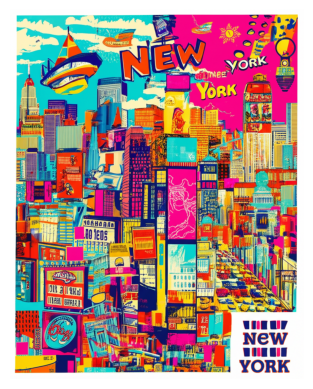

In [25]:
# Show the image with matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image(file_name):
    img = mpimg.imread(file_name)
    imgplot = plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()
show_image("vacation_in_New York.png")

# Our Agent Framework

The term 'Agentic AI' and Agentization is an umbrella term that refers to a number of techniques, such as:

1. Breaking a complex problem into smaller steps, with multiple LLMs carrying out specialized tasks
2. The ability for LLMs to use Tools to give them additional capabilities
3. The 'Agent Environment' which allows Agents to collaborate
4. An LLM can act as the Planner, dividing bigger tasks into smaller ones for the specialists
5. The concept of an Agent having autonomy / agency, beyond just responding to a prompt - such as Memory

We're showing 1 and 2 here, and to a lesser extent 3 and 5. In week 8 we will do the lot!

In [30]:
def chat(history):
    messages = [{"role": "system", "content": system_message}] + history
    response = openai.chat.completions.create(model=model, messages=messages, tools=tools)
    image = None
    
    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        image = generate(city)
        response = openai.chat.completions.create(model=model, messages=messages)
        
    reply = response.choices[0].message.content
    history += [{"role":"assistant", "content":reply}]

    # Comment out or delete the next line if you'd rather skip Audio for now..
    #talker(reply)
    
    
    
    return history, image

In [ ]:
import gradio as gr

# More involved Gradio code as we're not using the preset Chat interface!
# Passing in inbrowser=True in the last line will cause a Gradio window to pop up immediately.

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
    with gr.Row():
        entry = gr.Textbox(label="Chat with our AI Assistant:")
    with gr.Row():
        clear = gr.Button("Clear")

    def do_entry(message, history):
        history += [{"role":"user", "content":message}]
        return "", history

    entry.submit(do_entry, inputs=[entry, chatbot], outputs=[entry, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, image_output]
    )
    clear.click(lambda: None, inputs=None, outputs=chatbot, queue=False)

ui.launch(inbrowser=False)

* Running on local URL:  http://127.0.0.1:7865

To create a public link, set `share=True` in `launch()`.


Tool get_ticket_price called for London
vacation_in_London


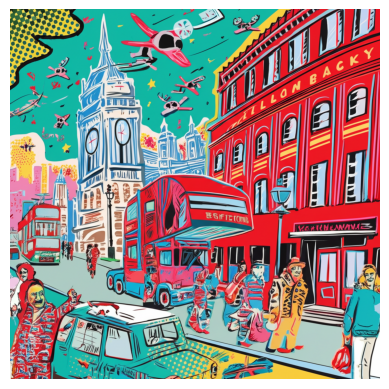

In [32]:
show_image("vacation_in_London.png")

# Exercises and Business Applications

Add in more tools - perhaps to simulate actually booking a flight. A student has done this and provided their example in the community contributions folder.

Next: take this and apply it to your business. Make a multi-modal AI assistant with tools that could carry out an activity for your work. A customer support assistant? New employee onboarding assistant? So many possibilities! Also, see the week2 end of week Exercise in the separate Notebook.

<table style="margin: 0; text-align: left;">
    <tr>
        <td style="width: 150px; height: 150px; vertical-align: middle;">
            <img src="../thankyou.jpg" width="150" height="150" style="display: block;" />
        </td>
        <td>
            <h2 style="color:#090;">I have a special request for you</h2>
            <span style="color:#090;">
                My editor tells me that it makes a HUGE difference when students rate this course on Udemy - it's one of the main ways that Udemy decides whether to show it to others. If you're able to take a minute to rate this, I'd be so very grateful! And regardless - always please reach out to me at ed@edwarddonner.com if I can help at any point.
            </span>
        </td>
    </tr>
</table>

In [37]:
import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr
import datetime

# Load the openai model
load_dotenv(override=True)
token = os.getenv("GITHUB_TOKEN")
endpoint = "https://models.inference.ai.azure.com"

model = "gpt-4o-mini"

openai = OpenAI(
    base_url=endpoint,
    api_key=token,
)

# System message
system_message = "You are a helpful assistant for an Airline called FlightAI. "
system_message += "Give short, courteous answers, no more than 1 sentence. "
system_message += "Always be accurate. If you don't know the answer, say so."

# Tool functions
ticket_prices = {"london": "$799", "paris": "$899", "tokyo": "$1400", "berlin": "$499"}
flight_schedule = {
    "london": [
        {"time": "08:00", "duration": "2h 30m"},
        {"time": "12:00", "duration": "2h 45m"},
    ],
    "paris": [
        {"time": "10:00", "duration": "1h 15m"},
        {"time": "14:00", "duration": "1h 30m"},
    ],
    "tokyo": [
        {"time": "09:00", "duration": "11h 30m"},
        {"time": "17:00", "duration": "12h 00m"},
    ],
    "berlin": [
        {"time": "07:00", "duration": "1h 45m"},
        {"time": "11:00", "duration": "2h 00m"},
    ],
}

def get_ticket_price(destination_city):
    """Gets the price of a return ticket to the destination city."""
    print(f"Tool get_ticket_price called for {destination_city}")
    city = destination_city.lower()
    return ticket_prices.get(city, "Unknown")

def get_flight_times(destination_city):
    """Gets the flight times for the destination city."""
    print(f"Tool get_flight_times called for {destination_city}")
    city = destination_city.lower()
    return flight_schedule.get(city, "Unknown")

def book_flight(destination_city, departure_date, passenger_name):
    """Books a flight to the destination city on the specified date for the passenger."""
    print(
        f"Tool book_flight called for {destination_city} on {departure_date} for {passenger_name}"
    )
    # Basic validation (Expand this)
    if (
        destination_city.lower() not in ticket_prices
        or not departure_date
        or not passenger_name
    ):
        return "Booking failed. Please provide valid information."

    try:
        datetime.datetime.strptime(departure_date, "%Y-%m-%d")  # Check date format
    except ValueError:
        return "Booking failed. Invalid date format. Please use YYYY-MM-DD."

    # In a real system, you would interact with a database or booking API here.
    booking_confirmation = f"Flight to {destination_city} on {departure_date} for {passenger_name} is confirmed."
    return booking_confirmation

# Tool descriptions
price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price, for example when a customer asks 'How much is a ticket to this city'",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False,
    },
}

flight_times_function = {
    "name": "get_flight_times",
    "description": "Get the flight times for the destination city.  Call this when the user asks for flight times.",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False,
    },
}

book_flight_function = {
    "name": "book_flight",
    "description": "Book a flight for the customer.  Call this when the customer wants to book a flight.",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
            "departure_date": {
                "type": "string",
                "description": "The date of departure in YYYY-MM-DD format",
            },
            "passenger_name": {
                "type": "string",
                "description": "The name of the passenger",
            },
        },
        "required": ["destination_city", "departure_date", "passenger_name"],
        "additionalProperties": False,
    },
}

tools = [
    {"type": "function", "function": price_function},
    {"type": "function", "function": flight_times_function},
    {"type": "function", "function": book_flight_function},
]

# Tool handling
def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    function_name = tool_call.function.name
    arguments = json.loads(tool_call.function.arguments)

    if function_name == "get_ticket_price":
        city = arguments.get("destination_city")
        price = get_ticket_price(city)
        response = {
            "role": "tool",
            "content": json.dumps({"destination_city": city, "price": price}),
            "tool_call_id": tool_call.id,
        }
        return response, city
    elif function_name == "get_flight_times":
        city = arguments.get("destination_city")
        times = get_flight_times(city)
        response = {
            "role": "tool",
            "content": json.dumps({"destination_city": city, "flight_times": times}),
            "tool_call_id": tool_call.id,
        }
        return response, city
    elif function_name == "book_flight":
        destination_city = arguments.get("destination_city")
        departure_date = arguments.get("departure_date")
        passenger_name = arguments.get("passenger_name")
        confirmation = book_flight(
            destination_city, departure_date, passenger_name
        )
        response = {
            "role": "tool",
            "content": json.dumps(
                {
                    "destination_city": destination_city,
                    "departure_date": departure_date,
                    "passenger_name": passenger_name,
                    "confirmation": confirmation,
                }
            ),
            "tool_call_id": tool_call.id,
        }
        return response, destination_city # Changed from city.

    return None, None  #Should never reach here.

# Chat function
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=model, messages=messages, tools=tools)

    if response.choices[0].finish_reason == "tool_calls":
        message = response.choices[0].message
        tool_response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(tool_response)
        response = openai.chat.completions.create(model=model, messages=messages)

    return response.choices[0].message.content

# Launch the Gradio interface
gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7870

To create a public link, set `share=True` in `launch()`.


Tool get_ticket_price called for Tokyo
Tool get_flight_times called for Tokyo
Tool book_flight called for Tokyo on 2025-04-05 for Eda
